## Reward Search Tau Macro

> Written by Jess Breda September 2023

Working based off of discussions from 09-14 meeting to add a "prev_rewarded" regressor. Similar to violations, will sweep over taus. This has one catch where it can only be applied to stage 4. In stage 3, both errors and hits are rewarded (albiet with a delay), so it would effectively encode violations. 

The goals for this NB are

1. Update design matrix generation for prev_reward

2. Test new experiment focused on prev_reward

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [107]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import DesignMatrixGenerator, ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from sigma_tau_search_experiment_reward import SigmaTauSearchExperimentReward
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [174]:
df = get_rat_viol_data(animal_ids=["W065"]).query("training_stage==4").iloc[200:240]

returning data for ['W065']


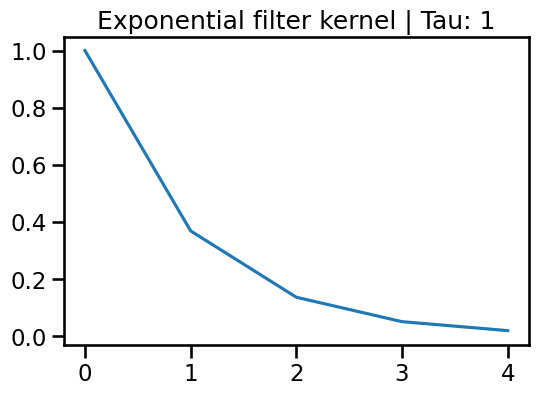

In [179]:
tau = 1
filter_obj = ExpFilter(tau=tau, column="prev_violation")
filter_obj.plot_kernel()

Exp filter added for session 54 | Column: prev_violation, Tau: 4
Exp filter added for session 55 | Column: prev_violation, Tau: 4


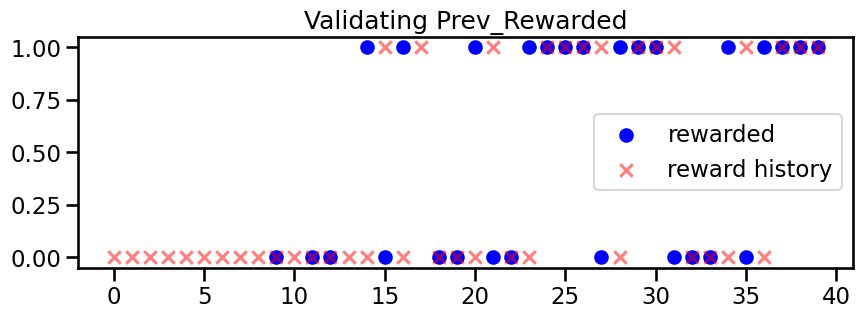

In [175]:
dmg = DesignMatrixGenerator()

xx, yy = dmg.generate_design_matrix(df, tau=0, filter_column="prev_rewarded")
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x=np.arange(len(df)), y=df.hit, color="blue", label="rewarded")
ax.scatter(
    x=np.arange(len(xx)),
    y=xx.prev_rewarded,
    color="red",
    marker="x",
    alpha=0.5,
    label="reward history",
)

# ax.plot(
#     np.arange(len(df)),
#     df.session - 50,
# )

plt.legend(loc="center right")
_ = plt.title("Validating Prev_Rewarded")

In [176]:
dmg = DesignMatrixGenerator()
tau = 1
xx, yy = dmg.generate_design_matrix(df, tau=tau, filter_column="prev_rewarded")
xx["hit"] = df.hit

Exp filter added for session 54 | Column: prev_violation, Tau: 4
Exp filter added for session 55 | Column: prev_violation, Tau: 4
Exp filter added for session 54 | Column: prev_rewarded, Tau: 1
Exp filter added for session 55 | Column: prev_rewarded, Tau: 1


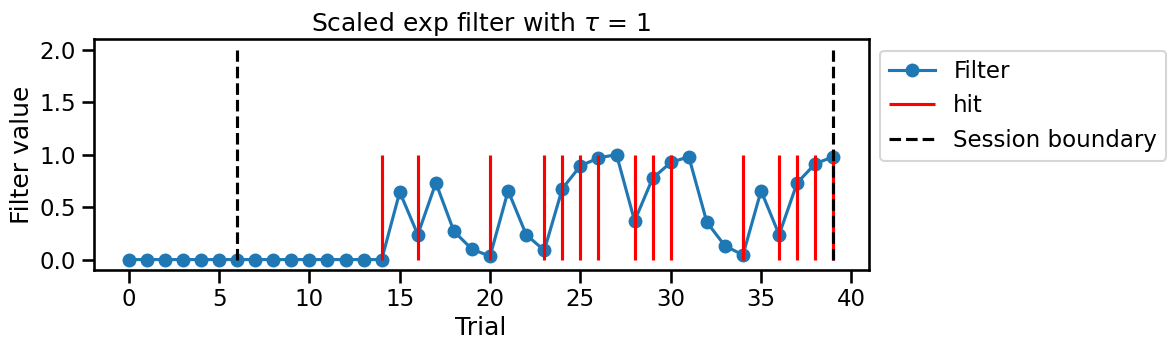

In [177]:
plot_kernel_validation(
    xx.reset_index(), kernel_column=f"prev_rewarded_exp_{tau}", reference_column="hit"
)

I seem to be getting an error that is specific to adding the prev_rewarded column

In [159]:
params = {
    "animals": None,
    "sigmas": [0, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5],
    "taus": [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 15, 18, 20, 25, 30],
    "random_state": 44,
    "test_size": 0.25,
}

experiment = SigmaTauSearchExperimentReward(params)

returning dataset for all animals


In [160]:
results = experiment.run()



 !!!!! evaluating animal W051 !!!!!


         Current function value: 447562.515804
         Iterations: 26
         Function evaluations: 72
         Gradient evaluations: 60
         Current function value: 447381.831505
         Iterations: 25
         Function evaluations: 57
         Gradient evaluations: 46
         Current function value: 447528.782633
         Iterations: 27
         Function evaluations: 83
         Gradient evaluations: 71
         Current function value: 447733.789831
         Iterations: 28
         Function evaluations: 122
         Gradient evaluations: 109
         Current function value: 447888.261620
         Iterations: 28
         Function evaluations: 109
         Gradient evaluations: 98
         Current function value: 447990.855640
         Iterations: 28
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 448057.861048
         Iterations: 28
         Function evaluations: 126
         Gradient

In [161]:
experiment.animals

array(['W051', 'W060', 'W061', 'W062', 'W065', 'W066', 'W068', 'W072',
       'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083',
       'W088', 'W089', 'W094'], dtype=object)

In [162]:
results.to_csv("prev_reward_macro_sweep.csv", index=False)

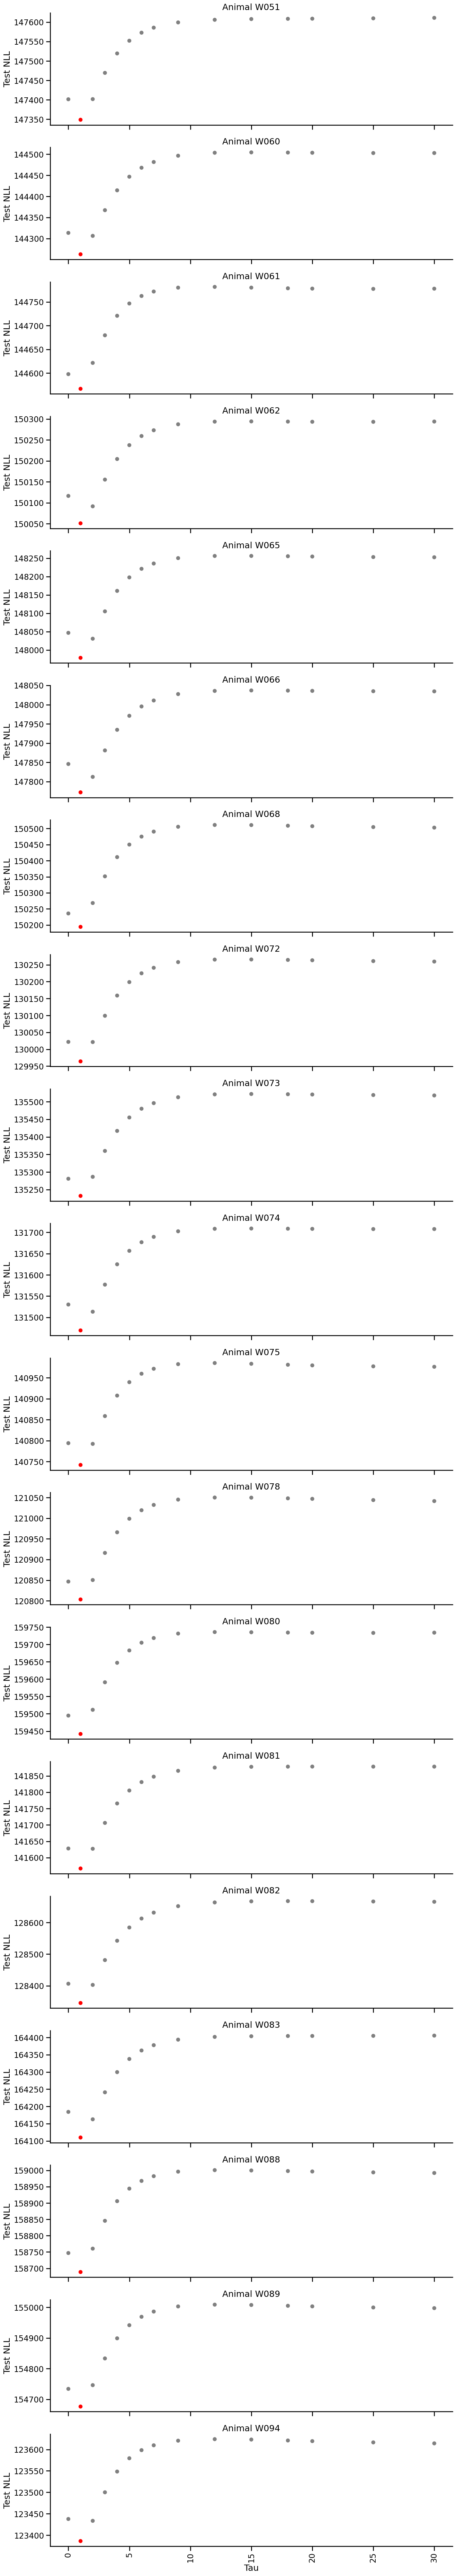

In [180]:
experiment.plot_nll_over_taus()

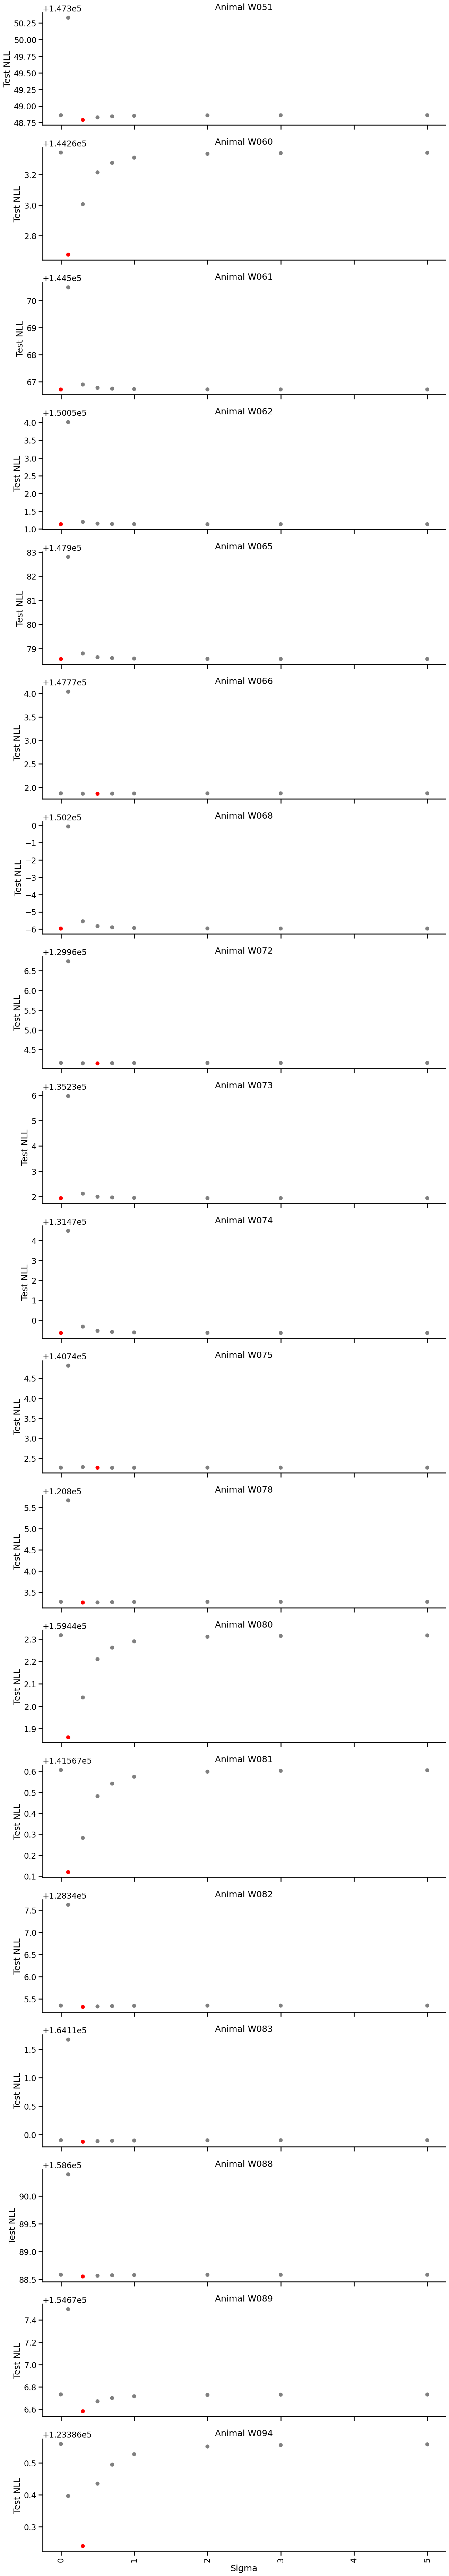

In [181]:
experiment.plot_nll_over_sigmas()

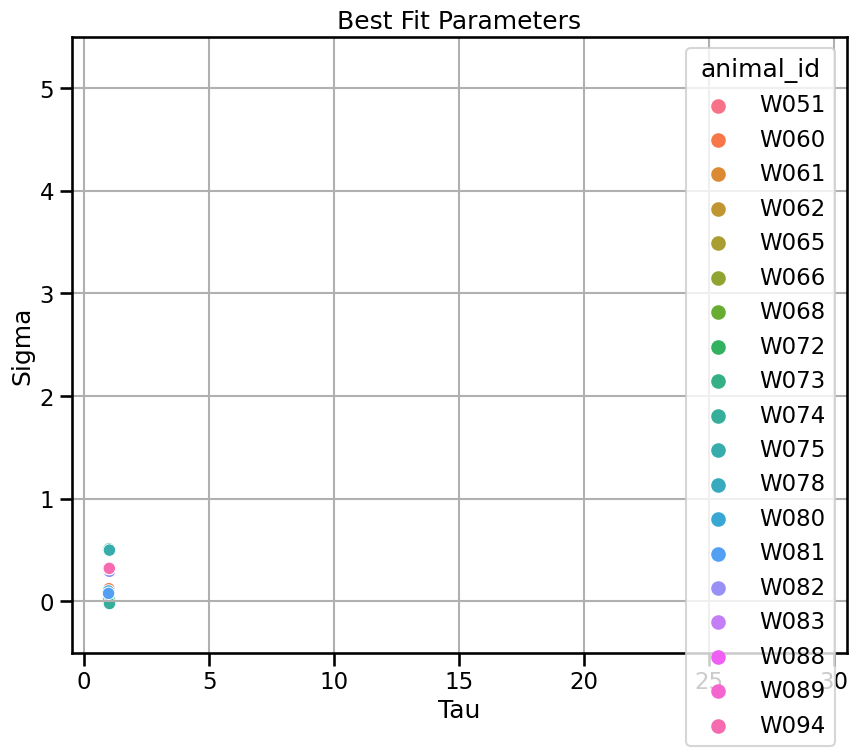

In [165]:
experiment.plot_best_sigma_tau_by_animal(jitter=0.025)

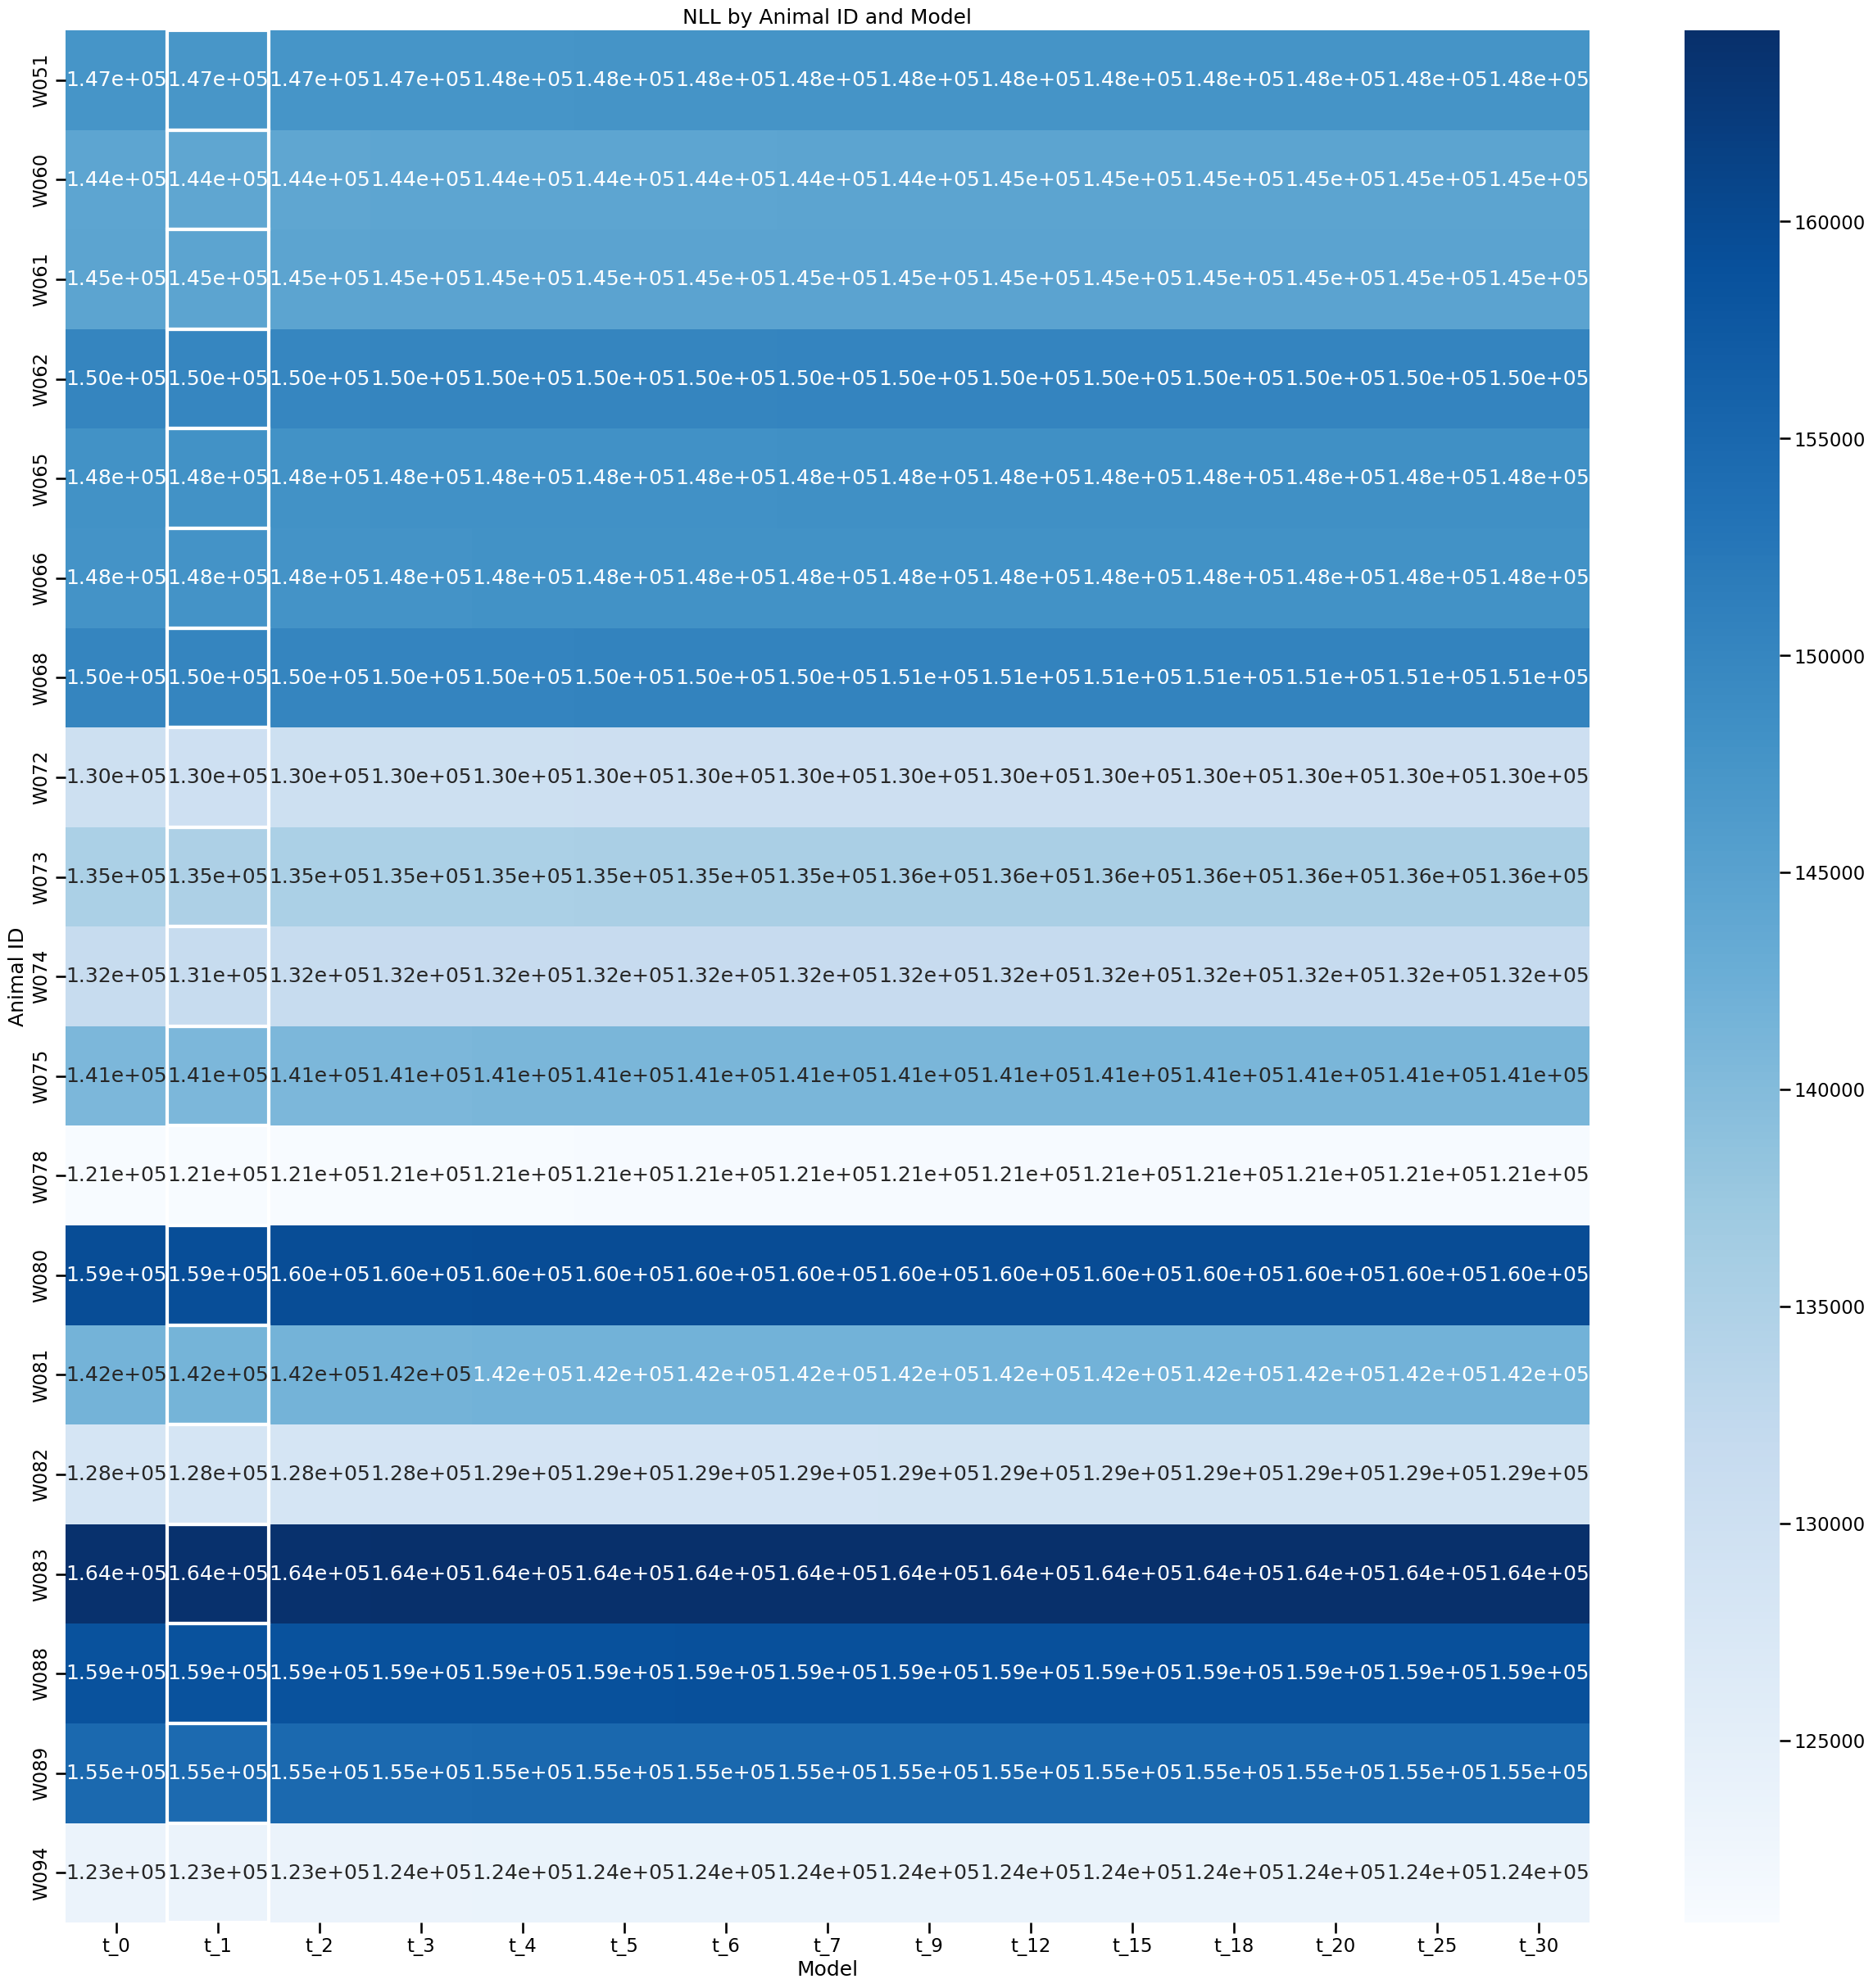

In [166]:
experiment.plot_tau_heatmap()

In [167]:
experiment.find_best_fit(group="animal_id")

,animal_id,model_name,sigma,tau,nll
0,W051,t_1,0.3,1,147348.791878
1,W060,t_1,0.1,1,144262.674419
2,W061,t_1,0.0,1,144566.720129
3,W062,t_1,0.0,1,150051.135210
4,W065,t_1,0.0,1,147978.562317
5,W066,t_1,0.5,1,147771.866797
6,W068,t_1,0.0,1,150194.030909
7,W072,t_1,0.5,1,129964.148572
8,W073,t_1,0.0,1,135231.936924
9,W074,t_1,0.0,1,131469.353557


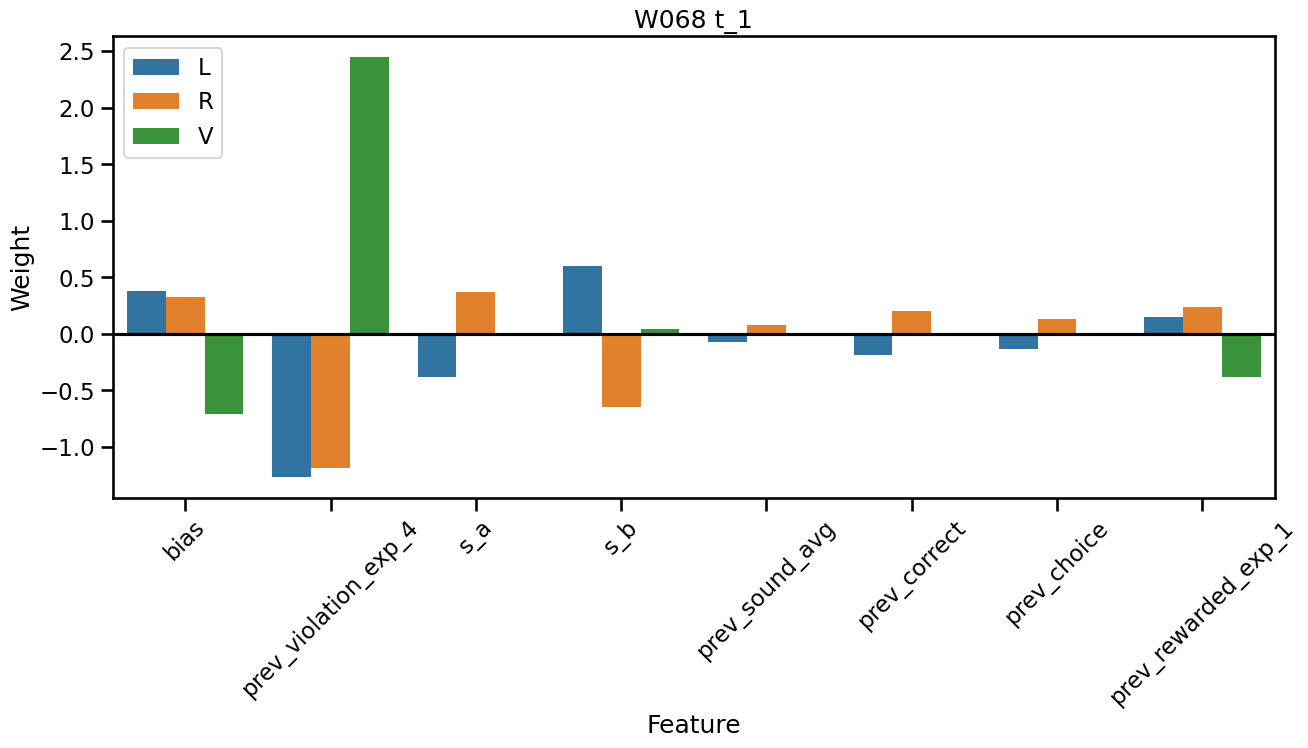

In [188]:
experiment.plot_class_weights(animal_id="W068", model_name="t_1")